# Detecting the difficulty level of French texts




In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%%capture
! pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

  0% 0.00/303k [00:00<?, ?B/s]
100% 303k/303k [00:00<00:00, 97.9MB/s]


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_data = pd.read_csv('training_data.csv', index_col = 'id')

In [ ]:
train_data.head()

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


In [ ]:
train_data.isnull().sum()

sentence      0
difficulty    0
dtype: int64

In [ ]:
train_data.duplicated().sum()

0

In [ ]:
X_data = train_data[['sentence']]

In [ ]:
y_data = train_data[['difficulty']]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [ ]:
y_train.shape[0]

3840

In [ ]:
X_train.shape[0]

3840

In [ ]:
%%capture
!pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.


In [ ]:
%%capture
!python -m spacy download fr_core_news_sm

2023-11-17 16:46:14.447779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 16:46:14.452765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 16:46:14.452858: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 16:46:14.492552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 16:46:17.919985: W tensorflow/compiler/

In [ ]:
import spacy
from spacy import displacy
import string
from nltk.stem.snowball import SnowballStemmer

In [ ]:
#french language
french = spacy.load('fr_core_news_sm')
stemmer = SnowballStemmer(language='french')

In [ ]:
test = "Bouygues a eu 1 coupure de réseau à Marseille."
test2 = "Par ailleurs, 42 % des adolescents déclarent qu'ils seraient dévastés s'ils devaient "

In [ ]:
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.fr.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = french(sentence)

    # Remove proper nouns (noms propres)
    mytokens = [word for word in mytokens if word.pos_ != "PROPN"]

    # Lemmatize each token and convert each token into lowercase
    mytokens = [stemmer.stem(X.text) for X in mytokens]

    # Remove numbers
    mytokens = [word for word in mytokens if not word.isdigit()]



    # Return preprocessed list of tokens
    return list(mytokens)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Définissez le vecteur TF-IDF avec votre fonction de tokenization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.90, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Ajoutez la normalisation avec StandardScaler
classifier = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

# Créez le pipeline avec la normalisation
pipe = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', classifier)
])

# Ajustez le modèle sur l'ensemble d'entraînement
pipe.fit(X_train['sentence'], y_train['difficulty'])


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', max_df=0.9, min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x7fa463f1caf0>)),
                ('classifier',
                 RandomForestClassifier(max_depth=3, n_estimators=200,
                                        random_state=0))])

In [ ]:
y_pred = pipe.predict(X_test['sentence'])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [ ]:
print(f'The accuracy using TF-IDF and Logistic Regression is: {round(accuracy_score(y_test["difficulty"], y_pred), 3)}')
#print(f'Accuracy of the best model: {accuracy_tfidf * 100:.2f}%')
print(f'\nThe precision using TF-IDF and Logistic Regression is: {round(precision_score(y_test["difficulty"], y_pred,average="macro"), 3)}')
print(f'\nThe recall using TF-IDF and Logistic Regression is: {round(recall_score(y_test["difficulty"], y_pred,average="macro"), 3)}')
print(f'\nThe F1-score using TF-IDF and Logistic Regression is: {round(f1_score(y_test["difficulty"], y_pred,average="macro"), 3)}')


The accuracy using TF-IDF and Logistic Regression is: 0.321

The precision using TF-IDF and Logistic Regression is: 0.364

The recall using TF-IDF and Logistic Regression is: 0.317

The F1-score using TF-IDF and Logistic Regression is: 0.285


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

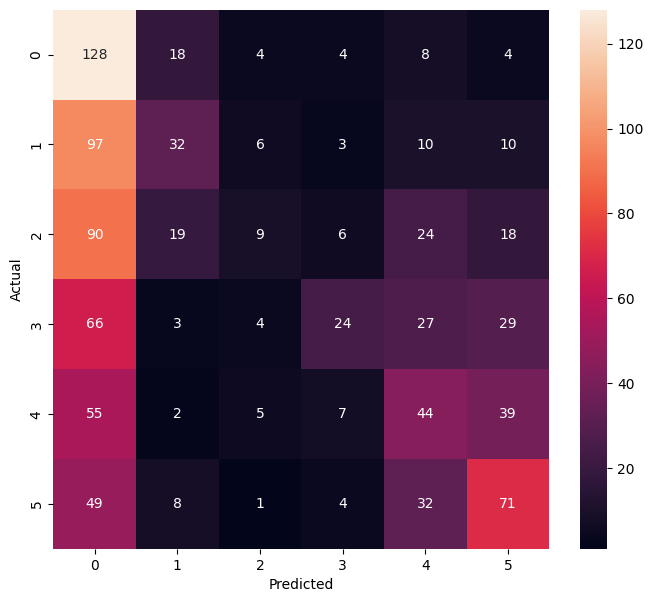

In [ ]:
## Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Testing various parameters with a gridsearch

In [ ]:
%%capture
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Définissez le vecteur TF-IDF avec votre fonction de tokenization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.90, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Définissez le classificateur RandomForestClassifier
classifier = RandomForestClassifier()

# Créez le pipeline
pipe = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', classifier)
])

# Définissez les paramètres à tester pour RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Utilisez GridSearchCV pour tester différentes combinaisons de paramètres
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Ajustez le modèle sur l'ensemble d'entraînement avec la recherche par grille
grid_search.fit(X_train['sentence'], y_train['difficulty'])

# Obtenez les meilleurs paramètres et le meilleur modèle
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Faites des prédictions sur l'ensemble de test avec le meilleur modèle
level_pred = best_model.predict(X_test['sentence'])

# Évaluez les performances du meilleur modèle
accuracy = accuracy_score(y_test['difficulty'], level_pred)
precision = precision_score(y_test['difficulty'], level_pred, average='macro')
recall = recall_score(y_test['difficulty'], level_pred, average='macro')
f1 = f1_score(y_test['difficulty'], level_pred, average='macro')

# Affichez les résultats
print(f'The best parameters: {best_params}')
print(f'The accuracy using TF-IDF and RandomForestClassifier is: {round(accuracy, 3)}')
print(f'The precision using TF-IDF and RandomForestClassifier is: {round(precision, 3)}')
print(f'The recall using TF-IDF and RandomForestClassifier is: {round(recall, 3)}')
print(f'The F1-score using TF-IDF and RandomForestClassifier is: {round(f1, 3)}')


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extr